### Imports

In [1]:
from heeps.util.coord import polar_coord
from heeps.util.img_processing import resize_img, pad_img
from heeps.pupil.create_pupil import create_pupil
from heeps.optics import detector
from copy import deepcopy
import time
import proper
from astropy.io import fits
import astropy.convolution as astroconv
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mpro
from functools import partial
from sys import platform
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


### Inputs

In [2]:
maskM1 = fits.getdata('input_files/ELT_pupil/mask_M1.fits')
spiders = fits.getdata('input_files/ELT_pupil/SpiderShadow.fits')
nimg = 10526                # size of the high-res pupil image
phot_spiders_L = 3.5        # pixels on the spiders (for 1 inside the pupil)
phot_spiders_N = 4.3
phot_envirnt_L = 4.3        # pixels outside the pupil (for 1 inside the pupil)
phot_envirnt_N = 5.1
spi_width = 0.54            # spider width in m
pupil_img_size = 39.9988    # pupil image in m
# nominal diameters
diam_nominal_ext = 38.542
diam_nominal_int = 10.952
# all-glass diameters
diam_allglass_ext = 36.905
diam_allglass_int = 11.213
# averaged full-M1 diameters
diam_fullM1_ext = 37.812
diam_fullM1_int = 10.196
# IMG-PP1 diameters in mm
pupil_size_IMG_PP1 = 45
pupil_img_size_IMG_PP1 = pupil_size_IMG_PP1*pupil_img_size/diam_nominal_ext

### Definitions of functions, step by step

In [3]:
''' Step 1: Take the ELT pupil mask (outer & inner edges + spiders), and make a 
reasonable assumption on how bright each region would look wrt each other. Here 
we used the on-sky case, for which we have some estimates (Roy's input), but we 
could also use the WCU pupil config if we are provided with relevant information.'''
def pupil_emission(phot_envirnt, phot_spiders):
    pup = maskM1*(1 + (1 - spiders)*(phot_spiders - 1)) + (1 - maskM1)*phot_envirnt
    plt.imshow(pup, origin='lower')
    return pup

def background_emission(phot_envirnt, phot_spiders):
    pup = maskM1*((1 - spiders)*phot_spiders) + (1 - maskM1)*phot_envirnt
    plt.imshow(pup, origin='lower')
    return pup

''' Step 2: Convolve our high-res model of the pupil emission with a kernel.'''
def convolve_pupil(pup, kernel, verbose=True):
    t0 = time.time()
    pup_conv = astroconv.convolve(pup, kernel, boundary='extend')
    if verbose is True:
        plt.imshow(pup_conv, origin='lower')
        print('duration=%s s'%round(time.time() - t0))
    return pup_conv

### Background thermal emission

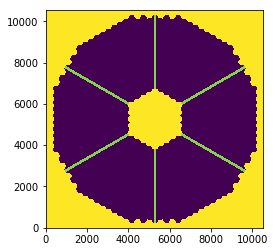

In [6]:
pup = background_emission(phot_envirnt_L, phot_spiders_L)
fits.writeto('Pupil_blurring/background_emission_L.fits', pup, overwrite=True)

### Huygens PSF

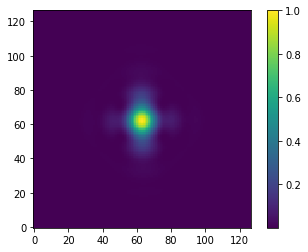

In [6]:
file = 'Pupil_blurring/METIS_IMG-LM_PP1_Huygens_PSF/METIS_IMG-LM_PP1_HuygensPSF+6mmPiston_data.txt'
kernel = np.loadtxt(file , delimiter='\t', encoding='utf-16', skiprows=21)
kernel = np.delete(kernel, 0, 0)
kernel = np.delete(kernel, 0, 1)
data_spacing = 0.014239 # data spacing in mm
nkernel = kernel.shape[0]
kernel_size = nkernel*data_spacing
plt.imshow(kernel, origin='lower')
plt.colorbar()

### Convolve

duration=161 s


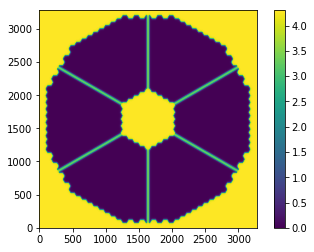

In [8]:
pup = fits.getdata('Pupil_blurring/background_emission_L.fits')
npupil_IMG_PP1 = np.ceil(nkernel*pupil_img_size_IMG_PP1/kernel_size)
pup = resize_img(pup, int(npupil_IMG_PP1))
pup_img = convolve_pupil(pup, kernel)
plt.colorbar()
fits.writeto('Pupil_blurring/HuygensPSF+6mmPiston/pup_img_L.fits', pup_img, overwrite=True)

### Pupil image (log scale), with all-glass limits marked

/mnt/diskss/home/mshinde/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


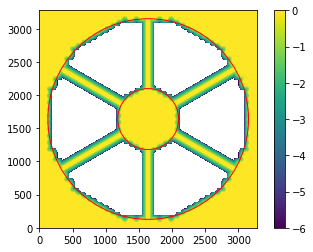

In [7]:
pup_img = fits.getdata('Pupil_blurring/HuygensPSF+6mmPiston/pup_img_L.fits')
figure, ax = plt.subplots()
c = pup_img.shape
ax.add_patch(plt.Circle((c[0]/2, c[1]/2), (pup_img.shape[0]/pupil_img_size)*(diam_allglass_ext/2), color='red', fill=False))
ax.add_patch(plt.Circle((c[0]/2, c[1]/2), (pup_img.shape[0]/pupil_img_size)*(diam_allglass_int/2), color='red', fill=False))
plt.imshow(np.log10(pup_img), origin='lower')
plt.clim(0, -6)
plt.colorbar()
plt.savefig('Pupil_blurring/HuygensPSF+6mmPiston/pup_img_log_scale.png', dpi=300, transparent=True)

### Blurred part of the pupil image

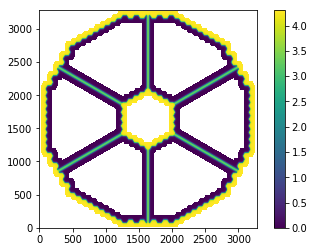

In [3]:
pup_img = fits.getdata('Pupil_blurring/HuygensPSF+6mmPiston/pup_img_L.fits')
pup_img = np.where(pup_img==phot_envirnt_L, np.nan, pup_img)
pup_img = np.where(pup_img==phot_spiders_L, np.nan, pup_img)
pup_img = np.where(pup_img==0, np.nan, pup_img)
figure, ax = plt.subplots()
#c = pup_img.shape
#ax.add_patch(plt.Circle((c[0]/2, c[1]/2), (pup_img.shape[0]/pupil_img_size)*(diam_allglass_ext/2), color='red', fill=False))
#ax.add_patch(plt.Circle((c[0]/2, c[1]/2), (pup_img.shape[0]/pupil_img_size)*(diam_allglass_int/2), color='red', fill=False))
plt.imshow(pup_img, origin='lower')
plt.set_cmap('viridis')
plt.colorbar()
plt.savefig('Pupil_blurring/HuygensPSF+6mmPiston/blurred_part_pup_img.png', dpi=300, transparent=True)

### Initialize wavefront using PROPER

In [4]:
# 1. Create a config dictionary with your simulation parameters. 
conf = dict(
    band = 'L',
    mode = 'ELT',
    dir_output = 'Pupil_blurring/HuygensPSF+6mmPiston',
    f_pupil = 'pupil/ELT_fullM1.fits',
    f_lyot_stop = '',
    add_phase = False,
    send_to = None, #'cdelacroix@uliege.be',
    nframes = 1,
    cpu_count = 30
)
conf = heeps.config.read_config(verbose=True, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf) 
cpu_count = conf['cpu_count']
wf = heeps.pupil.pupil(savefits=True,  norm_I=False, verbose=True, **conf)
pup_img = fits.getdata('Pupil_blurring/HuygensPSF+6mmPiston/pup_img_L.fits')
pup_img = resize_img(np.float32(pup_img), conf['npupil'])

Default config: band=L, mode=ELT
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   npupil=285, pscale=5.47 mas, lam=3.8100E-06 m
   ndet=365 (-> hfov=1.0 arcsec, 46.88 lam/D)

Simulation config: band=L, mode=ELT
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)

Load pupil from 'ELT_fullM1.fits'


### Create Lyot stop

In [5]:
def create_ls(d_ext, d_int, ls_dRext, ls_dRint, ls_dRspi):
    # create spider stop
    conf = dict(
        npupil=nimg,
        pupil_img_size=pupil_img_size, 
        diam_ext=80,        # no circular aperture
        diam_int=0,         # no circular obscuration
        seg_width=0,        # no segments
        spi_width=spi_width + ls_dRspi*diam_nominal_ext,
    )
    mask_spi = create_pupil(**conf)
    # create outer and inner stops
    r_ext = (d_ext - ls_dRext*diam_nominal_ext) / pupil_img_size
    r_int = (d_int + ls_dRint*diam_nominal_ext) / pupil_img_size
    r, t = polar_coord(nimg)
    mask_ext = (r < r_ext) 
    mask_int = (r > r_int) 
    # lyot stop
    return mask_spi * mask_ext * mask_int

### Propagate functions

In [6]:
def propag_one(r_pup, r_spi, verbose=False):
    #create ls
    ls = create_ls(diam_allglass_ext, diam_allglass_int, r_pup, r_pup, r_spi)
    ls = resize_img(np.float32(ls), conf['npupil'])
    #background flux
    overlay = pup_img*ls
    flux = np.sum(overlay)
    #throughput
    wf1 = deepcopy(wf)
    proper.prop_multiply(wf1, pad_img(ls, conf['ngrid']))
    psf = detector(wf1, verbose=verbose, **conf)
    thruput = np.sum(psf)
    # fraction of bacground flux relative to flux from pupil
    rel_flux = flux/thruput
    return rel_flux

In [7]:
def propag_multi(r_pups, r_spis, cpu_count=cpu_count, verbose=False):
    npup = len(r_pups)
    nspi = len(r_spis)
    cube = []
    t0 = time.time()
    if cpu_count != 1 and platform in ['linux', 'linux2', 'darwin']:
        if cpu_count == None:
            cpu_count = mpro.cpu_count() - 1
        print('   %s: Pupil blurring simulation starts, using %s cores'\
            %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), cpu_count))
        p = mpro.Pool(cpu_count)
        func = partial(propag_one)
        cube = np.array(p.starmap(func, zip(np.repeat(r_pups, nspi), np.tile(r_spis, npup))))
        p.close()
        p.join()
    else:
        print('   %s: Pupil blurring starts, using 1 core'\
            %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
        for r_pup in r_pups:
            for r_spi in r_spis:
                cube.append(propag_one(r_pup, r_spi))
    cube = np.array(cube)
    cube = cube.reshape(npup, nspi)
    print('   %s: finished, elapsed %.3f seconds'\
        %(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), time.time() - t0))
    return np.array(cube)

### Relative background flux

   2021-04-22 16:14:38: Pupil blurring simulation starts, using 30 cores
   2021-04-22 17:07:59: finished, elapsed 3200.625 seconds


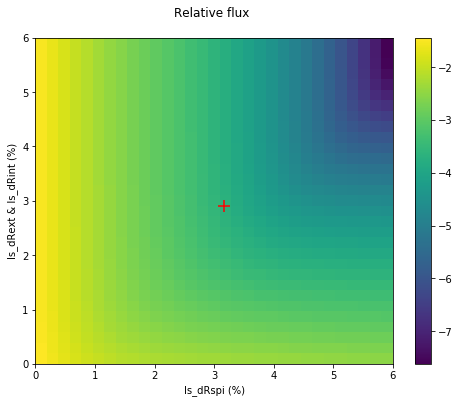

In [8]:
rp = np.arange(0, 0.061, 0.002)
rs = np.arange(0, 0.061, 0.002)
relative_flux = propag_multi(rp, rs)
np.savetxt('Pupil_blurring/HuygensPSF+6mmPiston/rel_bgrd_flux.txt', relative_flux, delimiter=',')
fig, ax = plt.subplots(figsize = (8,6))
plt.imshow(np.log10(relative_flux), origin='lower', extent=(rs[0],rs[-1],rp[0],rp[-1]), aspect='auto', cmap='viridis')
plt.colorbar()
plt.scatter(0.0317, 0.0291, s=150, c='red', marker='+')
plt.ylabel('ls_dRext & ls_dRint (%)');
plt.xlabel('ls_dRspi (%)');
plt.title('Relative flux \n ');
ax.set_xticklabels([0,1, 2, 3, 4, 5, 6])
ax.set_yticklabels([0,1, 2, 3, 4, 5, 6])
plt.savefig('Pupil_blurring/HuygensPSF+6mmPiston/2D_map_rel_bgrd_flux.png', dpi=300, transparent=True)